# Personality Analysis by Country
This notebook contains the code to perform personality analysis across countries. All data resides in the *data* folder, but due to the size restrictions these files are not present in the repo.

## Preprocessing

In [38]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import json
from helpers import *
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load all speakers from the parquet file
speakers = pd.read_parquet('data/speaker_attributes.parquet')

In [3]:
speakers.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None


For this analysis, we would like select some number of speakers to represent their country. We will use the *nationality* column in our speakers data. Since this column contains an array of nationalities for each person, for simplicity we will choose the first one.

In [4]:
# Get nationalities (first one)
nationalities = speakers.nationality.apply(lambda nt: nt[0] if nt is not None else None)

In [5]:
# Find unique nationalities excluding None
unique_nat_qids = np.unique(nationalities[nationalities.values != None])

Let's see how many different nationalities we have in the dataset.

In [6]:
len(unique_nat_qids)

2704

We got 2704, but this is quite odd, as there are around 200 countries/nationalities in the world. Let's see what kind of nationalities are these. Since we only have QIDs for these nationalities, we will use the **wikidata** python library to get the wikidata information programmatically. We have put the helper functions as usual in the **helpers.py**

In [11]:
# Since loading these wikidata entities takes a long time, we will just look at a sample of 10
nationality_sample = []
for qid in unique_nat_qids[:10]:
    entity = get_wiki_entity(qid)
    nationality_sample.append(entity.label)

In [12]:
nationality_sample

[m'Gabon',
 m'Orkney Islands',
 m'United States of America',
 m'Sanada clan',
 m'Judaea',
 m'The Gambia',
 m'Canadian nationality law',
 m'Guinea',
 m'Guinea-Bissau',
 m'Pali kingdom']

Aha! We can see that there are some bogus nationality entries in our data like 'Canadian nationality law'. Seems like we need some pruning to identify the true countries. For this, we can check the wikidata attributes offline in WikiData and realize that the true countries are instance of an entity unsurprisingly called *country*. So, we will filter out nationalities based on this attribute next.

In [13]:
# Get all existing country entities
countries = get_countries(unique_nat_qids)

Let's check the number of countries now.

In [14]:
len(countries)

230

This seems about right. Let's check some sample of the countries to confirm.

In [16]:
[country.label for country in list(countries.values())[:10]]

[m'Gabon',
 m'The Gambia',
 m'Guinea',
 m'Guinea-Bissau',
 m"Côte d'Ivoire",
 m'Cameroon',
 m'Cape Verde',
 m'Lesotho',
 m'Liberia',
 m'Libya']

Great! Let's save these QIDs for later easy retrieval.

In [72]:
country_qids = list(countries.keys())
with open('data/country_qids.json', 'w') as f:
    f.write(json.dumps({'qids': country_qids}))

Next, we are going to identify the speakers for these countries. This next cell will take some time to run, so we will save its results as well once it is finished.

<font color='red'>WARNING: LONG EXECUTION!</font>

In [73]:
# Find speakers for those valid countries
country_speakers = speakers[speakers.nationality.apply(lambda nt: any([cid in nt for cid in country_qids]) if nt is not None else False)]

In [78]:
# Save for later easy retrieval
country_speakers.id.to_csv('data/country_speaker_qids.csv')

In [22]:
# Load data from saved files
country_speaker_qids = pd.read_csv('data/country_speaker_qids.csv')
country_speakers = speakers[speakers.id.isin(country_speaker_qids.id)]

with open('data/country_qids.json') as f:
    country_qids = json.load(f)['qids']

countries = {qid: get_wiki_entity(qid) for qid in country_qids}

Let's see how many people we have identified belonging to a valid country out of all speakers.

In [23]:
f"all={len(speakers)}, with_valid_country={len(country_speakers)}"

'all=9055981, with_valid_country=3164693'

Wow! We have pruned almost two thirds of the speakers. Let's who are some of these people who are not identified to belong to an existing country.

In [24]:
non_country_speakers = speakers[~speakers.id.isin(country_speaker_qids.id)]

In [27]:
non_country_speakers.head(15)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
7,"[Mikołaj Kopernik, Nikolaus Kopernikus, Copern...",[+1473-02-19T00:00:00Z],[Q1649871],[Q6581097],1394975677,[Q1026],None,"[Q11063, Q185351, Q188094, Q170790, Q16012028,...",None,None,Q619,Nicolaus Copernicus,None,item,[Q1841]
10,None,[+1606-06-06T00:00:00Z],[Q70972],[Q6581097],1395437957,[Q121842],None,"[Q214917, Q49757, Q333634, Q36180, Q1209498]",None,None,Q747,Pierre Corneille,None,item,[Q1841]
13,"[Platon, Aristocles]","[-0427-05-07T00:00:00Z, -0429-05-21T00:00:00Z]",[Q844930],[Q6581097],1393026075,[Q539051],None,"[Q4964182, Q26237228, Q49757]",None,None,Q859,Plato,None,item,None
16,[Andrei D. Sakharov],[+1921-05-21T00:00:00Z],"[Q15180, Q2305208]",[Q6581097],1373398920,[Q49542],None,"[Q169470, Q1476215, Q16742096]",None,[Q17281097],Q997,Andrei Sakharov,None,item,[Q7066]
17,None,"[+1896-06-06T00:00:00Z, +1896-01-01T00:00:00Z]",[Q172579],[Q6581097],1388733064,None,None,"[Q47064, Q82955, Q2095549]",[Q139596],[Q1054679],Q1056,Italo Balbo,None,item,None
29,[Marcus Salvius Otho],[+0032-04-28T00:00:00Z],[Q1747689],[Q6581097],1372905634,None,None,[Q82955],None,None,Q1416,Otho,None,item,[Q337547]
30,"[Titus Flavius Vespasianus, Emperor of Rome Ti...","[+0041-00-00T00:00:00Z, +0040-12-30T00:00:00Z,...",[Q1747689],[Q6581097],1394376651,None,None,"[Q82955, Q47064]",None,None,Q1421,Titus,None,item,[Q337547]
32,"[Ramesses, Pa-ra-mes-su, Menpehtyre, Rameses]",[-1300-00-00T00:00:00Z],[Q11768],[Q6581097],1388567331,None,None,[Q2304859],None,None,Q1526,Ramesses I,None,item,None
40,"[Emperor of Rome Gordianus III, Emperor of Rom...",[+0225-01-20T00:00:00Z],[Q1747689],[Q6581097],1382333078,None,None,[Q82955],None,None,Q1812,Gordian III,None,item,[Q337547]
61,"[Franciszek Karpinski, Franciszek Karpiński]",[+1741-10-04T00:00:00Z],[Q172107],[Q6581097],1387626215,[Q1026],None,"[Q49757, Q333634, Q214917, Q36180, Q182436]",None,None,Q3547,Franciszek Karpiński,None,item,None


Interesting. Seems like we have a lot of speakers from ancient times or simply not identified people (None). Before moving onto our analysis, let's visualize which countries are most represented. For this, we will need to get some more info on the country entities from the wikidata such as 3-letter ISO code so that we can use it later for visualization and to possibly merge external geolocation data.

In [28]:
# We will save this data for later retrieval as well
country_info = {qid: get_country_info(qid) for qid in country_qids}
with open('data/country_info.json', 'w') as f:
    json.dump(country_info, f)

In [29]:
# Load saved file
with open('data/country_info.json') as f:
    country_info = json.load(f)

In [30]:
list(country_info.items())[:5]

[('Q1000', {'name': 'Gabon', 'iso': 'GAB'}),
 ('Q1005', {'name': 'The Gambia', 'iso': 'GMB'}),
 ('Q1006', {'name': 'Guinea', 'iso': 'GIN'}),
 ('Q1007', {'name': 'Guinea-Bissau', 'iso': 'GNB'}),
 ('Q1008', {'name': "Côte d'Ivoire", 'iso': 'CIV'})]

We will create a new column on the **country_speakers** called *country* from first entries in the *nationality* column.

In [32]:
country_speakers = country_speakers.copy()
country_speakers['country'] = country_speakers.nationality.apply(lambda n: n[0])

Then we group by this new column and append the country info like name and ISO code from the *country_info* data.

In [34]:
country_speakers_grouped = country_speakers.groupby('country').agg({'id': 'count'})

In [35]:
country_speakers_grouped.head()

,id
country,
Q1000,371
Q100166,1
Q1005,727
Q1006,621
Q1007,222


In [36]:
country_speakers_grouped['country_name'] = country_speakers_grouped.index.map(lambda cid: country_info[cid]['name'] if cid in country_info else None)
country_speakers_grouped['country_iso'] = country_speakers_grouped.index.map(lambda cid: country_info[cid]['iso'] if cid in country_info else None)

In [37]:
country_speakers_grouped.head()

,id,country_name,country_iso
country,,,
Q1000,371,Gabon,GAB
Q100166,1,None,None
Q1005,727,The Gambia,GMB
Q1006,621,Guinea,GIN
Q1007,222,Guinea-Bissau,GNB


Let's finally visualize it using an interactive map.

In [61]:
fig = visualize_world(country_speakers_grouped, location_col='country_iso', color_col='id', hover_col='country_name', title='Number of speakers', labels={'id': 'speakers'}, color_scale=px.colors.sequential.Turbo)
fig.write_html("static/world-speakers.html")

We can clearly see that US is the most represented country while the whole continent of Africa is almost not represented and most of Latin American countries except Brazil and Argentina, Middle Asia and Middle East are amongst the underrepresented countries.

Now, we will proceed with our similar preprocessing to get the speakers with significant number of quotes.

In [62]:
with open('data/signi-quote-count-combined_1636253317430.json') as f:
    signi_quote_count_dict = json.load(f)

In [63]:
signi_quote_count_df = pd.Series(signi_quote_count_dict, name='signi_quote_count')

In [64]:
# Merge these country speakers with speakers who have significant number of quotes
signi_country_speakers = country_speakers.merge(signi_quote_count_df, left_on='id', right_index=True, how='inner')

In [65]:
len(signi_country_speakers)

436152

This reduced our number of speakers from 3mln to around 450k.

In [69]:
signi_country_speakers.country.nunique()

330

Seems like we still have some countries that might not be a valid country. Let's remove those rows.

In [70]:
signi_country_speakers = signi_country_speakers[signi_country_speakers.country.isin(country_qids)].copy()

In [71]:
signi_country_speakers.country.nunique()

218

Much better. Let's move on to select certain number of speakers per country to represent it. We will do some more analysis on the underrepresented countries before moving onto selecting speakers.

In [72]:
# Speakers grouped by country
speakers_by_country = signi_country_speakers.groupby('country')

In [73]:
speakers_by_country.size()

country
Q1000     35
Q1005    113
Q1006     91
Q1007     24
Q1008    174
        ... 
Q971      48
Q974     179
Q977      11
Q983      12
Q986      49
Length: 218, dtype: int64

In [90]:
speakers_by_country.size().min(), speakers_by_country.size().median(), speakers_by_country.size().max()

(1, 174.5, 146354)

In [77]:
speakers_by_country.count().sort_values(by=['id'], ascending=False)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion,signi_quote_count
country,,,,,,,,,,,,,,,,
Q30,33018,132911,146354,146212,146354,9632,1488,143738,15662,1264,146354,146354,157,146354,4568,146354
Q145,11708,45758,48253,48172,48253,481,0,47502,2617,268,48253,48253,1678,48253,1127,48253
Q16,3359,21193,23965,23941,23965,218,0,23024,3106,119,23965,23965,800,23965,397,23965
Q408,3883,16570,18272,18239,18272,123,0,17969,2100,64,18272,18272,388,18272,318,18272
Q183,1741,16754,17033,17032,17033,100,0,16671,2600,1327,17033,17033,461,17033,694,17033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q2444884,1,2,2,2,2,1,0,2,0,0,2,2,0,2,1,2
Q25279,1,2,2,2,2,0,0,2,1,0,2,2,0,2,0,2
Q12060881,0,1,1,1,1,0,0,1,0,0,1,1,0,1,0,1


Let's now compare by quote count.

In [78]:
country_agg = speakers_by_country.agg({'id': 'count', 'signi_quote_count': 'sum'})

In [79]:
# Number of countries who have less than 10 speakers in the dataset
(country_agg.id < 10).sum()

20

In [80]:
# Number of countries who have less than 10 quotes
(country_agg.signi_quote_count < 10).sum()

6

In [81]:
# Let's see who are these underrepresented countries by speaker count
underrep_countries = list(country_agg[country_agg.id < 10].index)
[countries[c].label for c in underrep_countries]

[m'Imperial China',
 m'Northern Mariana Islands',
 m'South Vietnam',
 m'Aruba',
 m'Vatican City',
 m'Republic of Artsakh',
 m'Tibet',
 m'Curaçao',
 m'Cook Islands',
 m'Irish Free State',
 m'Niue',
 m'Somaliland',
 m'Sahrawi Arab Democratic Republic',
 m'German Empire',
 m'Zaire',
 m'Federated States of Micronesia',
 m'Danish Realm',
 m'Republic of Upper Volta',
 m'Turkmenistan',
 m'Transnistria']

In [82]:
# Now by quote count
underrep_countries_by_quote = list(country_agg[country_agg.signi_quote_count < 10].index)
[countries[c].label for c in underrep_countries_by_quote]

[m'Imperial China',
 m'Republic of Artsakh',
 m'Zaire',
 m'Republic of Upper Volta',
 m'Turkmenistan',
 m'Transnistria']

In [83]:
country_agg[country_agg.index.isin(underrep_countries)]

,id,signi_quote_count
country,,
Q12060881,1,1
Q16644,7,394
Q180573,2,10
Q21203,5,39
Q237,2,37501
Q244165,1,1
Q2444884,2,24
Q25279,2,18
Q26988,8,172


Here we see the quote count for speakerwise underrepresented countries. Most of the those countries also have relatively small number of quotes, however, there is one extreme outlier which has 37501 quotes. Let's see who this country is.

In [84]:
country_info['Q237']

{'name': 'Vatican City', 'iso': 'VAT'}

Right, this makes sense now. There is only one person, The Pope who is quoted from Vatican City, but he has been quoted quite many times. Enough fun with the data, let's move on to some more serious stuff. We will select top 50 speakers for each country, although as we have seen some countries dont have that many. We will choose 100 so that it is not too many to be able to process it later and not to few either.

In [91]:
def select_top_speakers(speaker_group, top_k=100):
    speaker_group = speaker_group.sort_values(by=['signi_quote_count'], ascending=False)
    return speaker_group.iloc[:top_k]

selected_country_speakers = speakers_by_country.apply(select_top_speakers).reset_index(drop=True)

In [93]:
selected_country_speakers.sort_values(by=['signi_quote_count'], ascending=False).head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion,country,signi_quote_count
6792,"[Donald John Trump, Donald J. Trump, Trump, Th...",[+1946-06-14T00:00:00Z],[Q30],[Q6581097],1395141850,None,None,"[Q911554, Q557880, Q3427922, Q15980158, Q13152...","[Q29468, Q1897793, Q29552, Q29468, Q29468]",[Q787674],Q22686,Donald Trump,"[Q699872, Q22923830, Q38051523]",item,[Q178169],Q30,201293
9292,"[Namo, Modi, Narendra Bhai, Narendra Damodarda...",[+1950-09-17T00:00:00Z],[Q668],[Q6581097],1395415052,"[Q1282294, Q6889284]",None,"[Q82955, Q36180, Q7019111, Q10429346]",[Q10230],None,Q1058,Narendra Modi,"[Q63988227, Q63988919, Q16841231, Q16251961, Q...",item,[Q9089],Q668,76404
6793,"[Barack Hussein Obama II, Barack Obama II, Bar...",[+1961-08-04T00:00:00Z],[Q30],[Q6581097],1395141963,"[Q49085, Q6935055, Q12826303, Q6392846]",O000167,"[Q82955, Q40348, Q15958642, Q28532974, Q372436]",[Q29552],"[Q1765120, Q1540185]",Q76,Barack Obama,"[Q3586671, Q45578, Q4226, Q4791768, Q17067714,...",item,"[Q23540, Q1062789, Q960252, Q426316]",Q30,59650
5484,"[Jorge Mario Bergoglio, Francisco, Pope Franci...",[+1936-12-17T00:00:00Z],"[Q237, Q414]",[Q6581097],1396054797,[Q1056744],None,"[Q63173086, Q593644, Q104050302, Q36180, Q1234...",None,[Q1233889],Q450675,Francis,None,item,[Q9592],Q237,37218
3076,"[Jürgen Norbert Klopp, Jurgen Klopp, Juergen K...",[+1967-06-16T00:00:00Z],[Q183],[Q6581097],1389758184,None,None,"[Q937857, Q628099]",None,None,Q83106,Jürgen Klopp,None,item,[Q75809],Q183,33025


In [94]:
# Let's save it for later retrieval
selected_country_speakers.to_parquet('data/rep100_country_speakers.parquet')

<font color='red'>WARNING: LONG EXECUTION!</font>

In [95]:
from functools import partial

years = [2015, 2016, 2017, 2018, 2019, 2020]
speaker_qids = selected_country_speakers.id.to_list() 
output_list = []

for year in years:
    path_to_input = PATTERN_INPUT.format(year)
    
    # Process quote file
    output_name = process_compressed_json_file(path_to_input, 'data/country-speaker-quotes100', year, partial(check_if_speaker_quote, speakers=speaker_qids))
    
    output_list.append(output_name)

print('\n\nOutput file names:')
for file_name in output_list:
    print(file_name)

Processing year 2015: 37it [01:30,  2.41s/it]

In [2]:
country_sp_quotes_2015 = read_json('data/country-speaker-quotes-2015_1639002396480.json')
country_sp_quotes_2016 = read_json('data/country-speaker-quotes-2016_1639004467042.json')
country_sp_quotes_2017 = read_json('data/country-speaker-quotes-2017_1639008783813.json')
country_sp_quotes_2018 = read_json('data/country-speaker-quotes-2018_1639050881392.json')
country_sp_quotes_2019 = read_json('data/country-speaker-quotes-2019_1639059907080.json')
country_sp_quotes_2020 = read_json('data/country-speaker-quotes-2020_1639060864568.json')

In [3]:
country_sp_quotes_2015, _ = filter_quotes(country_sp_quotes_2015)
country_sp_quotes_2016, _ = filter_quotes(country_sp_quotes_2016)
country_sp_quotes_2017, _ = filter_quotes(country_sp_quotes_2017)
country_sp_quotes_2018, _ = filter_quotes(country_sp_quotes_2018)
country_sp_quotes_2019, _ = filter_quotes(country_sp_quotes_2019)
country_sp_quotes_2020, _ = filter_quotes(country_sp_quotes_2020)

In [4]:
country_sp_quotes_2015_concat = concatenate_quotes(country_sp_quotes_2015)
country_sp_quotes_2016_concat = concatenate_quotes(country_sp_quotes_2016)
country_sp_quotes_2017_concat = concatenate_quotes(country_sp_quotes_2017)
country_sp_quotes_2018_concat = concatenate_quotes(country_sp_quotes_2018)
country_sp_quotes_2019_concat = concatenate_quotes(country_sp_quotes_2019)
country_sp_quotes_2020_concat = concatenate_quotes(country_sp_quotes_2020)

In [5]:
country_sp_quotes_2015_df = pd.Series(country_sp_quotes_2015_concat, name='quotations')
country_sp_quotes_2016_df = pd.Series(country_sp_quotes_2016_concat, name='quotations')
country_sp_quotes_2017_df = pd.Series(country_sp_quotes_2017_concat, name='quotations')
country_sp_quotes_2018_df = pd.Series(country_sp_quotes_2018_concat, name='quotations')
country_sp_quotes_2019_df = pd.Series(country_sp_quotes_2019_concat, name='quotations')
country_sp_quotes_2020_df = pd.Series(country_sp_quotes_2020_concat, name='quotations')


In [6]:
selected_country_speakers = pd.read_parquet('data/rep_country_speakers.parquet')

In [7]:
country_quotes_2015_df = selected_country_speakers.merge(country_sp_quotes_2015_df, left_on='id', right_index=True, how='inner')
country_quotes_2016_df = selected_country_speakers.merge(country_sp_quotes_2016_df, left_on='id', right_index=True, how='inner')
country_quotes_2017_df = selected_country_speakers.merge(country_sp_quotes_2017_df, left_on='id', right_index=True, how='inner')
country_quotes_2018_df = selected_country_speakers.merge(country_sp_quotes_2018_df, left_on='id', right_index=True, how='inner')
country_quotes_2019_df = selected_country_speakers.merge(country_sp_quotes_2019_df, left_on='id', right_index=True, how='inner')
country_quotes_2020_df = selected_country_speakers.merge(country_sp_quotes_2020_df, left_on='id', right_index=True, how='inner')

In [9]:
country_quotes_2015_df

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion,signi_quote_count,country,quotations
0,None,[+1996-09-19T00:00:00Z],[Q1000],[Q6581097],1367630304,None,None,[Q3665646],None,None,Q20880774,Chris Silva,None,item,None,218,Q1000,"Since becoming a public company one year ago,..."
1,[Mario René Junior Lemina],[+1993-09-01T00:00:00Z],[Q1000],[Q6581097],1349199504,None,None,[Q937857],None,None,Q13780454,Mario Lemina,None,item,None,104,Q1000,brings physical strength to Juventus `central...
2,None,[+1942-11-24T00:00:00Z],[Q1000],[Q6581097],1320314694,None,None,"[Q193391, Q82955]",[Q1762536],None,Q58286,Jean Ping,None,item,None,88,Q1000,We did not say anything serious except the tr...
3,None,[+1959-02-09T00:00:00Z],[Q1000],[Q6581097],1356040176,[Q810747],None,"[Q193391, Q82955, Q40348]",[Q1762536],None,Q57521,Ali Bongo Ondimba,"[Q22227440, Q3031394]",item,[Q432],36,Q1000,We were delighted to be chosen as the host na...
4,None,[+1986-01-30T00:00:00Z],[Q1000],[Q6581097],1367638687,None,None,"[Q19204627, Q19841381]",None,None,Q7361376,Rolly Lumbala,None,item,None,26,Q1000,"Watching him grow over the years, just when y..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9016,None,[+1974-00-00T00:00:00Z],[Q986],[Q6581097],1273008360,None,None,None,None,None,Q7635953,Sulaiman Addonia,None,item,None,4,Q986,Is it worth risking my life for?
9032,None,[+1978-00-00T00:00:00Z],[Q986],[Q6581072],1311043977,None,None,"[Q1930187, Q49757]",None,None,Q17318884,Saba Kidane,None,item,None,1,Q986,We are in a country governed by the rule of l...
9034,"[Berehet Selassie, Bereket Habte Selassie]",None,[Q986],[Q6581097],1313140678,None,None,None,None,None,Q4891228,Bereket Selassie,None,item,None,1,Q986,It's just comforting to know I can track it a...
9036,None,[+1989-10-24T00:00:00Z],[Q986],[Q6581097],1315780675,None,None,"[Q13381753, Q4439155]",None,None,Q5639644,Hais Welday,None,item,None,1,Q986,After that I am going alone.


In [22]:
country_quotes_2015_df[['id', 'quotations']].to_csv('data/country_quotes_2015.csv', index=False)
country_quotes_2016_df[['id', 'quotations']].to_csv('data/country_quotes_2016.csv', index=False)
country_quotes_2017_df[['id', 'quotations']].to_csv('data/country_quotes_2017.csv', index=False)
country_quotes_2018_df[['id', 'quotations']].to_csv('data/country_quotes_2018.csv', index=False)
country_quotes_2019_df[['id', 'quotations']].to_csv('data/country_quotes_2019.csv', index=False)
country_quotes_2020_df[['id', 'quotations']].to_csv('data/country_quotes_2020.csv', index=False)

In [10]:
country_quotes_2015_liwc = pd.read_csv('data/country_quotes_2015_liwc.csv')
country_quotes_2016_liwc = pd.read_csv('data/country_quotes_2016_liwc.csv')
country_quotes_2017_liwc = pd.read_csv('data/country_quotes_2017_liwc.csv')
country_quotes_2018_liwc = pd.read_csv('data/country_quotes_2018_liwc.csv')
country_quotes_2019_liwc = pd.read_csv('data/country_quotes_2019_liwc.csv')
country_quotes_2020_liwc = pd.read_csv('data/country_quotes_2020_liwc.csv')

In [11]:
country_personality_2015 = predict_personality(country_quotes_2015_liwc)
country_personality_2016 = predict_personality(country_quotes_2016_liwc)
country_personality_2017 = predict_personality(country_quotes_2017_liwc)
country_personality_2018 = predict_personality(country_quotes_2018_liwc)
country_personality_2019 = predict_personality(country_quotes_2019_liwc)
country_personality_2020 = predict_personality(country_quotes_2020_liwc)


In [12]:
country_personality_2015.set_index(country_quotes_2015_liwc.A, inplace=True)
country_personality_2016.set_index(country_quotes_2016_liwc.A, inplace=True)
country_personality_2017.set_index(country_quotes_2017_liwc.A, inplace=True)
country_personality_2018.set_index(country_quotes_2018_liwc.A, inplace=True)
country_personality_2019.set_index(country_quotes_2019_liwc.A, inplace=True)
country_personality_2020.set_index(country_quotes_2020_liwc['Source (A)'], inplace=True)

In [13]:
country_personality_2015 = country_personality_2015.merge(country_quotes_2015_df[['id', 'label', 'country']], left_index=True, right_on='id', how='inner')
country_personality_2016 = country_personality_2016.merge(country_quotes_2016_df[['id', 'label', 'country']], left_index=True, right_on='id', how='inner')
country_personality_2017 = country_personality_2017.merge(country_quotes_2017_df[['id', 'label', 'country']], left_index=True, right_on='id', how='inner')
country_personality_2018 = country_personality_2018.merge(country_quotes_2018_df[['id', 'label', 'country']], left_index=True, right_on='id', how='inner')
country_personality_2019 = country_personality_2019.merge(country_quotes_2019_df[['id', 'label', 'country']], left_index=True, right_on='id', how='inner')
country_personality_2020 = country_personality_2020.merge(country_quotes_2020_df[['id', 'label', 'country']], left_index=True, right_on='id', how='inner')

In [14]:
country_personality_2015

,neuroticism,anxiety,hostility,depression,self_consciousness,immoderation,vulnerability,extraversion,friendliness,gregariousness,...,conscientiousness,self_efficacy,orderliness,dutifulness,achievement_striving,self_discipline,cautiousness,id,label,country
0,0.742246,0.670736,1.594222,-0.532646,0.819898,-0.432471,0.911807,1.979829,4.932964,4.834686,...,-0.341397,1.916964,1.073785,2.048684,0.429590,-0.463638,0.957231,Q20880774,Chris Silva,Q1000
1,1.851480,2.235034,2.576738,0.152739,1.381947,0.133521,2.065153,2.836347,4.169948,5.858243,...,-0.721307,1.544998,1.637070,1.479108,-0.314852,-0.827575,0.762087,Q13780454,Mario Lemina,Q1000
2,1.808717,1.823402,2.985127,0.925727,-2.413395,0.352584,0.602560,5.266027,5.868540,10.016238,...,-2.823779,0.014685,0.500424,0.456086,-2.250588,-2.176880,-1.691283,Q58286,Jean Ping,Q1000
3,-0.804748,-0.647020,0.510958,-1.747883,-1.448697,-1.055537,-0.519675,2.932343,5.942803,5.113399,...,0.846173,3.330483,1.043334,2.030965,0.385356,0.559771,1.169268,Q57521,Ali Bongo Ondimba,Q1000
4,-0.770521,-0.468869,1.052351,-0.468869,-1.989136,0.052097,-1.104447,4.311690,6.436912,7.332084,...,-0.593901,1.260737,0.145870,1.114867,-1.281576,-0.125032,0.083355,Q7361376,Rolly Lumbala,Q1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9016,3.143171,4.000400,3.000300,0.000000,3.428914,1.714457,4.000400,0.000000,0.000000,5.284943,...,0.000000,1.857329,3.143171,0.000000,0.000000,0.000000,0.000000,Q7635953,Sulaiman Addonia,Q986
9032,0.732788,1.196146,2.098390,-0.340117,-3.023139,-0.999303,0.415113,5.072588,5.705718,6.585013,...,-1.001268,2.754913,0.877900,0.560669,-0.976290,-0.658996,-0.464435,Q17318884,Saba Kidane,Q986
9034,3.644711,3.222024,3.533623,2.511139,3.399387,1.133623,2.044456,1.599949,1.245273,4.888656,...,-3.089116,-1.000409,0.533470,0.200051,-2.067195,-2.977823,-0.755749,Q4891228,Bereket Selassie,Q986
9036,5.272727,4.545455,4.545455,1.363636,3.181818,2.363636,2.545455,0.818182,2.454545,6.000000,...,-3.272727,0.181818,3.272727,1.545455,-3.818182,-0.272727,-1.545455,Q5639644,Hais Welday,Q986


In [15]:
def group_personality_by_country(personality):
    return personality.groupby('country').agg({'id': 'count', 'label': lambda ls: ','.join([l for l in ls if l]), **{attr: 'mean' for attr in PERSONALITY_ATTRS}})

country_personality_grouped_2015 = group_personality_by_country(country_personality_2015)
country_personality_grouped_2016 = group_personality_by_country(country_personality_2016)
country_personality_grouped_2017 = group_personality_by_country(country_personality_2017)
country_personality_grouped_2018 = group_personality_by_country(country_personality_2018)
country_personality_grouped_2019 = group_personality_by_country(country_personality_2019)
country_personality_grouped_2020 = group_personality_by_country(country_personality_2020)

In [21]:
personality_dfs = [country_personality_grouped_2015,
                   country_personality_grouped_2016,
                   country_personality_grouped_2017,
                   country_personality_grouped_2018,
                   country_personality_grouped_2019,
                   country_personality_grouped_2020]

In [83]:
for i, df in enumerate(personality_dfs):
    df.to_csv(f'data/country_personality_grouped_{2015+i}.csv')

In [44]:
for df in personality_dfs:
    df['country_iso'] = df.index.map(lambda cid: country_info[cid]['iso'])
    df['country_name'] = df.index.map(lambda cid: country_info[cid]['name'])

In [22]:
for df in personality_dfs:
    for attr in PERSONALITY_ATTRS:
        df[attr] = (df[attr] - df[attr].min()) / (df[attr].max() - df[attr].min())

In [101]:
visualize_country_personality(country_personality_grouped_2018, location_col='country_iso', color_col='depression', hover_col='country_name', color_scale=px.colors.sequential.turbid)

In [102]:
visualize_country_personality(country_personality_grouped_2019, location_col='country_iso', color_col='depression', hover_col='country_name', color_scale=px.colors.sequential.turbid)

In [103]:
visualize_country_personality(country_personality_grouped_2019, location_col='country_iso', color_col='anxiety', hover_col='country_name', color_scale=px.colors.sequential.turbid)

In [104]:
visualize_country_personality(country_personality_grouped_2016, location_col='country_iso', color_col='cheerfulness', hover_col='country_name', color_scale=px.colors.sequential.Rainbow)

In [105]:
visualize_country_personality(country_personality_grouped_2017, location_col='country_iso', color_col='cheerfulness', hover_col='country_name', color_scale=px.colors.sequential.Rainbow)

In [106]:
visualize_country_personality(country_personality_grouped_2018, location_col='country_iso', color_col='cheerfulness', hover_col='country_name', color_scale=px.colors.sequential.Rainbow)

In [113]:
visualize_country_personality(country_personality_grouped_2020, location_col='country_iso', color_col='cheerfulness', hover_col='country_name', color_scale=px.colors.sequential.Rainbow)

In [118]:
from wordcloud import WordCloud

def plot_wordcloud(df, country=None):
    df_grouped = df.groupby('country').agg({'quotations': lambda q: ' '.join(q)})
    if country:
        quotes = df_grouped.loc[country, 'quotations']
    else:
        quotes = ' '.join(df_grouped['quotations'])
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(quotes)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

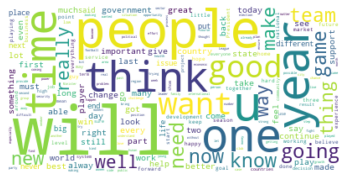

In [125]:
plot_wordcloud(country_quotes_2019_df)

In [87]:
world_gdp = pd.read_csv('data/world_gdp_per_capita.csv', skiprows=4)

In [88]:
world_gdp

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,24712.493263,26441.619936,26893.011506,28396.908423,28452.170615,29350.805019,30253.279358,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,GDP per capita (current US$),NY.GDP.PCAP.CD,147.836769,147.238537,156.426780,182.521139,162.594548,180.489043,...,1672.363658,1653.188436,1658.650062,1507.800256,1404.953164,1540.232473,1534.171767,1485.307425,1330.140232,NaN
2,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,59.773234,59.860900,58.458009,78.706429,82.095307,101.108325,...,641.871438,637.165464,613.856505,578.466353,509.220100,519.888913,493.756581,507.103392,508.808409,NaN
3,Africa Western and Central,AFW,GDP per capita (current US$),NY.GDP.PCAP.CD,107.963779,113.114697,118.865837,123.478967,131.892939,138.566819,...,1936.390962,2123.392433,2166.743309,1886.248158,1666.422406,1606.978332,1695.959215,1772.339155,1714.426800,NaN
4,Angola,AGO,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,5100.097027,5254.881126,5408.411700,4166.979833,3506.073128,4095.810057,3289.643995,2809.626088,1895.770869,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3596.804655,3891.266363,4080.330717,3603.025501,3780.003689,4045.614209,4419.914327,4445.890702,4287.200903,NaN
262,"Yemen, Rep.",YEM,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1446.536472,1607.152173,1674.002572,1601.830063,1138.603723,960.528848,824.117718,NaN,NaN,NaN
263,South Africa,ZAF,GDP per capita (current US$),NY.GDP.PCAP.CD,443.009920,454.962013,473.011405,511.497364,548.996058,584.704163,...,7501.661096,6832.725546,6433.400402,5734.633422,5272.543648,6131.479450,6372.605655,6001.401121,5090.715025,NaN
264,Zambia,ZMB,GDP per capita (current US$),NY.GDP.PCAP.CD,232.188564,220.042067,212.578449,213.896759,242.384473,303.281740,...,1763.069442,1878.346811,1762.427817,1338.290927,1280.806543,1535.196574,1516.371100,1305.002214,1050.919283,NaN


In [101]:
country_personality_grouped_2015_gdp = country_personality_grouped_2015.merge(world_gdp[["Country Code", "2015"]], left_on='country_iso', right_on="Country Code", how='inner')
country_personality_grouped_2016_gdp = country_personality_grouped_2016.merge(world_gdp[["Country Code", "2016"]], left_on='country_iso', right_on="Country Code", how='inner')
country_personality_grouped_2017_gdp = country_personality_grouped_2017.merge(world_gdp[["Country Code", "2017"]], left_on='country_iso', right_on="Country Code", how='inner')
country_personality_grouped_2018_gdp = country_personality_grouped_2018.merge(world_gdp[["Country Code", "2018"]], left_on='country_iso', right_on="Country Code", how='inner')
country_personality_grouped_2019_gdp = country_personality_grouped_2019.merge(world_gdp[["Country Code", "2019"]], left_on='country_iso', right_on="Country Code", how='inner')
country_personality_grouped_2020_gdp = country_personality_grouped_2020.merge(world_gdp[["Country Code", "2020"]], left_on='country_iso', right_on="Country Code", how='inner')

In [94]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

data = country_personality_grouped_2018_gdp
# pca = PCA(2)
# pca_data = pca.fit_transform(data[PERSONALITY_ATTRS])
kmeans = KMeans(n_clusters=8)
clusters = kmeans.fit_predict(data[['depression', 'assertiveness']])

In [109]:
democracy_index = pd.read_csv('data/democracy_index.csv')

In [110]:
democracy_index

,geo,name,time,Democracy index (EIU),Electoral pluralism index (EIU),Government index (EIU),Political participation index(EIU),Political culture index (EIU),Civil liberties index (EIU),Change in democracy index (EIU)
0,afg,Afghanistan,2006,30.6,61.70,0.00,22.2,25.0,44.10,NaN
1,afg,Afghanistan,2007,30.4,56.70,3.95,22.2,25.0,44.10,-0.2
2,afg,Afghanistan,2008,30.2,51.70,7.90,22.2,25.0,44.10,-0.2
3,afg,Afghanistan,2009,27.5,38.35,7.90,25.0,25.0,41.15,-2.7
4,afg,Afghanistan,2010,24.8,25.00,7.90,27.8,25.0,38.20,-2.7
...,...,...,...,...,...,...,...,...,...,...
2496,zwe,Zimbabwe,2016,30.5,5.00,20.00,38.9,56.3,32.40,NaN
2497,zwe,Zimbabwe,2017,31.6,5.00,20.00,44.4,56.3,32.40,NaN
2498,zwe,Zimbabwe,2018,31.6,5.00,20.00,44.4,56.3,32.40,NaN
2499,zwe,Zimbabwe,2019,31.6,0.00,25.00,44.4,56.3,32.40,NaN


In [114]:
democracy_index.geo = democracy_index.geo.str.upper()

In [116]:
country_personality_grouped_2015_dem = country_personality_grouped_2015.merge(democracy_index[democracy_index.time == 2015][["geo", "Democracy index (EIU)"]], left_on='country_iso', right_on="geo", how='inner')
country_personality_grouped_2016_dem = country_personality_grouped_2016.merge(democracy_index[democracy_index.time == 2016][["geo", "Democracy index (EIU)"]], left_on='country_iso', right_on="geo", how='inner')
country_personality_grouped_2017_dem = country_personality_grouped_2017.merge(democracy_index[democracy_index.time == 2017][["geo", "Democracy index (EIU)"]], left_on='country_iso', right_on="geo", how='inner')
country_personality_grouped_2018_dem = country_personality_grouped_2018.merge(democracy_index[democracy_index.time == 2018][["geo", "Democracy index (EIU)"]], left_on='country_iso', right_on="geo", how='inner')
country_personality_grouped_2019_dem = country_personality_grouped_2019.merge(democracy_index[democracy_index.time == 2019][["geo", "Democracy index (EIU)"]], left_on='country_iso', right_on="geo", how='inner')
country_personality_grouped_2020_dem = country_personality_grouped_2020.merge(democracy_index[democracy_index.time == 2020][["geo", "Democracy index (EIU)"]], left_on='country_iso', right_on="geo", how='inner')

In [117]:
country_personality_grouped_2015_dem

,id,label,neuroticism,anxiety,hostility,depression,self_consciousness,immoderation,vulnerability,extraversion,...,self_efficacy,orderliness,dutifulness,achievement_striving,self_discipline,cautiousness,country_iso,country_name,geo,Democracy index (EIU)
0,15,"Chris Silva,Mario Lemina,Jean Ping,Ali Bongo O...",0.402901,0.414796,0.361398,0.345059,0.423755,0.378380,0.382066,0.668546,...,0.542937,0.385859,0.710470,0.364499,0.689538,0.603458,GAB,Gabon,GAB,37.6
1,31,"Fatou Bensouda,Omar Khan,Yahya Jammeh,Christop...",0.441295,0.335173,0.415019,0.409594,0.524267,0.381863,0.446722,0.518570,...,0.472632,0.397927,0.722311,0.384324,0.542433,0.634401,GMB,The Gambia,GMB,29.7
2,24,"Robert Sarah,Boubacar Keita,Amadou Diallo,Cell...",0.543901,0.454350,0.514942,0.487019,0.543544,0.431902,0.499977,0.507631,...,0.432501,0.463142,0.705291,0.318983,0.555861,0.558605,GIN,Guinea,GIN,31.4
3,8,"Domingos Simoes Pereira,Carlos Correia,Ciprian...",0.523190,0.448247,0.477844,0.370679,0.509332,0.438026,0.495335,0.451302,...,0.511544,0.572631,0.502588,0.445630,0.646221,0.649569,GNB,Guinea-Bissau,GNB,19.3
4,31,"Abdul Razak,Eric Bailly,Wilfried Bony,Kolo Tou...",0.518283,0.461306,0.481366,0.418651,0.596455,0.419980,0.513475,0.369274,...,0.490973,0.453723,0.743312,0.500821,0.593923,0.629149,CIV,Côte d'Ivoire,CIV,33.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,21,"Offrande Zanzala,Alain Mabanckou,Thierry Moung...",0.263632,0.115177,0.179220,0.045044,0.409373,0.118641,0.267029,0.372441,...,0.776467,0.422573,0.877252,0.453934,0.703575,0.843263,COG,Republic of the Congo,COG,29.1
162,37,"Denis Mukwege,Emmanuel Mudiay,Bismack Biyombo,...",0.492641,0.400514,0.452992,0.460578,0.519998,0.429926,0.482517,0.503514,...,0.471283,0.420516,0.692868,0.379901,0.561153,0.528517,COD,Democratic Republic of the Congo,COD,21.1
163,4,"Mohamed Youssef,Mahamoud Ali Youssouf,Ahmed Da...",0.758256,0.610035,0.862892,0.868992,0.688218,0.614744,0.537169,0.412068,...,0.007361,0.257484,0.461520,0.000000,0.000000,0.443152,DJI,Djibouti,DJI,29.0
164,8,"Sergio Barila,Felipe Ovono,Eric Moussambani,Ri...",0.598147,0.595284,0.527720,0.536323,0.640866,0.499673,0.597734,0.407382,...,0.436421,0.475785,0.844035,0.538091,0.708355,0.508338,GNQ,Equatorial Guinea,GNQ,17.7


In [125]:
import plotly.express as px
# cluster_data = pd.concat([pd.Series(clusters, name='clusters'), data.reset_index()], axis=1)
for attr in PERSONALITY_ATTRS:
    fig = px.scatter(country_personality_grouped_2018_dem, x=attr, y='Democracy index (EIU)', hover_data=['country_name'])
    fig.show()

In [50]:
df

,clusters,pca_x,pca_y,id,label,neuroticism,anxiety,hostility,depression,self_consciousness,...,sympathy,conscientiousness,self_efficacy,orderliness,dutifulness,achievement_striving,self_discipline,cautiousness,country_iso,country_name
0,0.0,0.435037,-0.300172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.008948,-0.082727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,-0.053378,-0.047809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.495888,-0.110563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,-0.190421,-0.209427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q971,NaN,NaN,NaN,13.0,"Offrande Zanzala,Alain Mabanckou,Thierry Moung...",0.117315,0.244413,0.134551,0.121783,0.162911,...,0.602565,0.898624,0.734608,0.494531,0.812097,0.857108,0.811468,0.839513,COG,Republic of the Congo
Q974,NaN,NaN,NaN,45.0,"Denis Mukwege,Emmanuel Mudiay,Bismack Biyombo,...",0.215543,0.315996,0.224217,0.295029,0.217182,...,0.480626,0.741809,0.641099,0.510224,0.727704,0.657407,0.687763,0.688646,COD,Democratic Republic of the Congo
Q977,NaN,NaN,NaN,6.0,"Mohamed Youssef,Mahamoud Ali Youssouf,Abdourah...",0.340458,0.293265,0.410568,0.484927,0.522147,...,0.380476,0.401504,0.468541,0.465491,0.876089,0.313630,0.279654,0.635966,DJI,Djibouti
Q983,NaN,NaN,NaN,4.0,"Roberto Mandje,Rita Bosaho,Agapito Mba Mokuy,F...",0.062582,0.160398,0.122604,0.096218,0.000000,...,0.475682,0.808480,0.737289,0.311493,0.640862,0.570169,0.761556,0.601212,GNQ,Equatorial Guinea
